In [90]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Leitura de instâncias

In [91]:
def read_dat_file(file_path):
    """"Função para a leitura das instâncias geradas"""
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # 1. Lendo quantidade de itens e períodos
    items, periods = map(int, lines[0].split())

    # 2. Lendo número de plantas
    num_plants = int(lines[1].strip())

    # 3. Lendo capacidades das plantas
    capacities = [int(lines[i + 2].strip()) for i in range(num_plants)]
    capacities = np.tile(capacities, (periods, 1)).T  # Repete as capacidades ao longo dos períodos (deixar na forma j, t)

    # 4. Lendo a matriz de produção (tempo de produção, tempo de setup, custo de setup, custo de produção)
    production_data = []
    start_line = 2 + num_plants
    production_time = np.zeros((items, num_plants))  # Inicializar listas para armazenar separadamente os tempos e custos
    setup_time = np.zeros((items, num_plants))
    setup_cost = np.zeros((items, num_plants))
    production_cost = np.zeros((items, num_plants))
    for i in range(num_plants * items):  # Preencher as matrizes com os dados lidos
        plant = i // items  # Determina a planta
        item = i % items    # Determina o item
        # Extrair os dados de cada linha
        prod_time, set_time, set_cost, prod_cost = map(float, lines[start_line + i].split())
        production_time[item, plant] = prod_time  # Preencher as respectivas matrizes
        setup_time[item, plant] = set_time
        setup_cost[item, plant] = set_cost
        production_cost[item, plant] = prod_cost

    # 5. Lendo os custos de inventário
    inventory_costs_line = start_line + num_plants * items
    inventory_costs = list(map(float, lines[inventory_costs_line].split()))  # Lê todos os valores de inventory_costs como uma única lista
    inventory_costs = np.array(inventory_costs).reshape(num_plants, -1)  # Divide a lista de custos de inventário por planta
    inventory_costs = inventory_costs.T  # Deixa na forma (i, j)

    # 6. Lendo a matriz de demanda (12 linhas)
    demand_matrix = []
    demand_start_line = inventory_costs_line + 1
    
    # Leitura inicial das demandas
    for i in range(periods):  # Lê as linhas de demandas para os períodos
        demands = list(map(int, lines[demand_start_line + i].split()))
        demand_matrix.append(demands)
    
    # Agora vamos dividir os valores de cada linha combinada entre as plantas
    final_demand_matrix = []
    for demands in demand_matrix:
        period_demand = []
        for j in range(num_plants):
            # Divide a demanda combinada por planta, assumindo que cada planta tem o mesmo número de itens
            plant_demand = demands[j*items:(j+1)*items]
            period_demand.append(plant_demand)
        final_demand_matrix.append(period_demand)
    
    # Transpor a matriz de demanda para o formato correto (itens, plantas, períodos)
    final_demand_matrix = np.array(final_demand_matrix)
    final_demand_matrix = np.transpose(final_demand_matrix, (2, 1, 0))  # Converte para o formato (itens, plantas, períodos)

    # 7. Reading transfer costs directly from the document as a matrix
    transfer_cost_matrix = []
    transfer_cost_line = demand_start_line + periods

    # Read the matrix of transfer costs line by line
    while transfer_cost_line < len(lines):
        line = lines[transfer_cost_line].strip()
        if line:
            # Split the line into individual cost values and convert them to float
            row = [float(value) for value in line.split()]
            transfer_cost_matrix.append(row)
        transfer_cost_line += 1

    # Convert to a numpy array (optional, if you want to work with numpy for matrix operations)
    transfer_costs = np.array(transfer_cost_matrix)

    return {"items": items,
            "periods": periods,
            "num_plants": num_plants,
            "capacities": capacities,
            "production_time": production_time,
            "setup_time": setup_time,
            "setup_cost": setup_cost,  
            "production_cost": production_cost,
            "inventory_costs": inventory_costs,
            "demand_matrix": final_demand_matrix,
            "transfer_costs": transfer_costs}


In [92]:
# Exemplo de uso
file_path = '../instancias/multi_plant_instances/AAA02_12_2_10.dat'
data = read_dat_file(file_path)
display(data)

{'items': 10,
 'periods': 12,
 'num_plants': 2,
 'capacities': array([[2812, 2812, 2812, 2812, 2812, 2812, 2812, 2812, 2812, 2812, 2812,
         2812],
        [3103, 3103, 3103, 3103, 3103, 3103, 3103, 3103, 3103, 3103, 3103,
         3103]]),
 'production_time': array([[4.9, 2.5],
        [4.2, 2.7],
        [4. , 4.2],
        [2.5, 1.1],
        [1.6, 2.5],
        [1.6, 4.6],
        [2.7, 3.4],
        [2.9, 5. ],
        [3.7, 4.3],
        [1.2, 1.8]]),
 'setup_time': array([[48.8, 59.2],
        [42. , 47.6],
        [42. , 72. ],
        [53.9, 70.5],
        [29.5, 65.6],
        [64.6, 23.2],
        [62. , 29.6],
        [19.8, 47.4],
        [33.9, 59.2],
        [69.9, 44.6]]),
 'setup_cost': array([[320.5,  88.5],
        [866.6, 320.5],
        [450.1, 550.6],
        [ 88. , 578.1],
        [593.3, 394. ],
        [713. , 390.3],
        [498.3, 123. ],
        [381.1, 767.1],
        [267. , 431.6],
        [396.8,  93.3]]),
 'production_cost': array([[1.7, 2.4],
  

# Modelagem

In [93]:
m = gp.Model('Lot-sizing Sambasivan and Yahya')

## Conjuntos

In [94]:
# Produtos (i)
I = np.array([_ for _ in range(data['items'])])
# Plantas (j)
J = np.array([_ for _ in range(data['num_plants'])])
# Períodos (t)
T = np.array([_ for _ in range(data['periods'])])

## Parâmetros

In [95]:
# Demanda (i, j, t)
d = np.array(data['demand_matrix'])
# Capacidade (j, t)
cap = np.array(data['capacities'])
# Tempo de produção (i, j)
b = np.array(data['production_time'])
# Tempo de setup (i, j)
f = np.array(data['setup_time'])
# Custo de produção (i, j)
c = np.array(data['production_cost'])
# Custo de setup (i, j)
s = np.array(data['setup_cost'])
# Custo de transporte (j, k)
r = np.array(data['transfer_costs'])
# Custo de estoque (i, j)
h = np.array(data['inventory_costs'])

## Variáveis de decisão

In [96]:
# Quantidade produzida (i, j, t)
X = m.addVars(I, J, T, vtype=GRB.CONTINUOUS, name='X')
# Quantidade estocada (i, j, t)
Q = m.addVars(I, J, T, vtype=GRB.CONTINUOUS, name='Q')
# Quantidade transportada (i, j, k(um outro j), t)
W = m.addVars(I, J, J, T, vtype=GRB.CONTINUOUS, name='W')
# Variável de setup (binária) (i, j, t)
Z = m.addVars(I, J, T, lb=0, ub=1, vtype=GRB.CONTINUOUS, name='Z')

## Função objetivo

In [97]:
expr_objetivo = sum(sum(sum(c[i, j] * X[i, j, t] + h[i, j] * Q[i, j, t] + s[i, j] * Z[i, j, t] + 
                            sum(r[j, k] * W[i, j, k, t] for k in J if k != j) for t in T) for j in J) for i in I)
m.setObjective(expr_objetivo, sense=GRB.MINIMIZE)

## Restrições

In [98]:
# Balanço de estoque (revisar comportamento)
# Período inicial
m.addConstrs((Q[i, j, t] == X[i, j, t] - sum(W[i, j, k, t] for k in J if k != j) + sum(W[i, l, j, t] for l in J if l != j) - d[i, j, t] for i in I for j in J for t in T if t == 0),
             name='restricao_balanco_estoque')
# Demais períodos
m.addConstrs((Q[i, j, t] == Q[i, j, t-1] + X[i, j, t] - sum(W[i, j, k, t] for k in J if k != j) + sum(W[i, l, j, t] for l in J if l != j) - d[i, j, t] for i in I for j in J for t in T if t > 0),
             name='restricao_balanco_estoque');

In [99]:
# Restrição que obriga setup (validar o range do r)
m.addConstrs((X[i, j, t] <= min((cap[j, t] - f[i, j]) / b[i, j], sum(sum(d[i, k, r] for r in range(t, T[-1] + 1)) for k in J)) * Z[i, j, t] for i in I for j in J for t in T)
             , name='restricao_setup');

In [100]:
# Restrição de capacidade
m.addConstrs((sum(b[i, j] * X[i, j, t] + f[i, j] * Z[i, j, t] for i in I) <= cap[j, t] for j in J for t in T)
             , name='restricao_capacidade');

In [101]:
m.update()
print(m)
print(m.Fingerprint)

<gurobi.Model Continuous instance Lot-sizing Sambasivan and Yahya: 504 constrs, 1200 vars, Parameter changes: Username=(user-defined)>
1311338229


# Investigação do caráter das demandas

A média das demandas de um produto i é igual entre períodos t ao agregar a demanda entre plantas?

In [102]:
# Produtos
I

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [103]:
# Plantas
J

array([0, 1])

In [104]:
# Períodos
T

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [105]:
# Demanda por produto por período
demanda_agregada = np.zeros(shape=(len(I), len(T)))
for i in I:
    for t in T:
        demanda_agregada[i, t] = sum(d[i, j, t] for j in J)
# Demanda por período por produto
# demanda_agregada = demanda_agregada.transpose()

In [106]:
average_demand_product = np.zeros(len(I))
for i in I:
    average_demand_product[i] = demanda_agregada[i].mean()

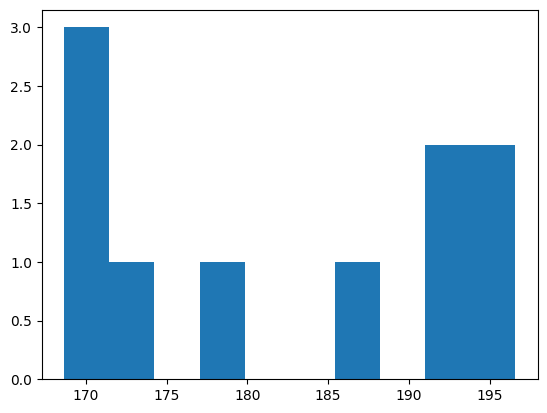

In [107]:
plt.hist(average_demand_product)
plt.show()

In [108]:
average_demand_period = np.zeros(len(T))
for t in T:
    average_demand_period[t] = demanda_agregada.transpose()[t].mean()

In [110]:
average_demand_period

array([184.4, 189.8, 212. , 147.8, 209.6, 173.2, 162.3, 151.1, 223. ,
       210.2, 179.3, 151.9])

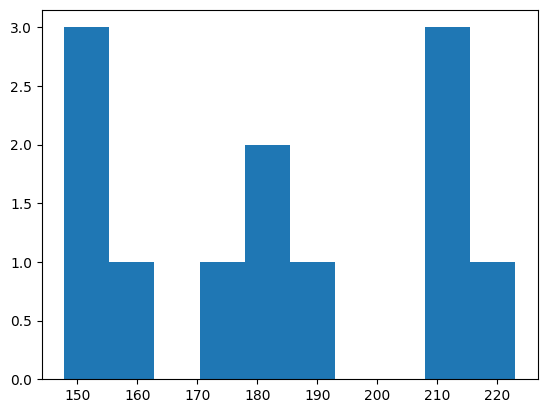

In [109]:
plt.hist(average_demand_period)
plt.show()